# Dataset retrieval

In [241]:
!pip install ucimlrepo

import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo

# Fetch the Adult Income dataset
adult = fetch_ucirepo(id=2)

# 3. Get the data as DataFrames
X_raw = adult.data.features
y_raw = adult.data.targets
X_raw['sex_encoded'] = X_raw['sex'].map({'Female': 0, 'Male': 1})
numerical_cols = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'sex_encoded']
X = X_raw[numerical_cols].values

# Problem Description
The extracted dataset comes from the UCI Machine Learning Repository and is made for classifying wether an adult makes over 50k a year or less based on census data. We are given a list of features such as sex, education, hours worked per week, among other to make predictions on a personas wage.

Data Source: https://archive.ics.uci.edu/dataset/2/adult

The dataset comes from a 1994 census where making 50k can be considered high income, that is no longer the case 30 years later.

# Creating Training and Test Sets

In [ ]:
# Convert income to binary (0 and 1)
y = y_raw['income'].str.replace('.', '', regex=False).str.strip()
y = (y == '>50K').astype(int).values.reshape(-1, 1)

# Scaling
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_scaled = (X - X_mean) / X_std

print(f"Data ready! Shape: {X_scaled.shape}")
print(f"Target distribution: {np.unique(y, return_counts=True)}")

Data ready! Shape: (48842, 6)
Target distribution: (array([0, 1]), array([37155, 11687]))


In [ ]:
# Shuffle all indices
m = X_scaled.shape[0]
indices = np.random.permutation(m)

# Define split sizes (e.g., 80% train, 20% test)
train_size = int(0.8 * m)

train_idx, test_idx = indices[:train_size], indices[train_size:]

# Create sets
X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print(f"Training set: {X_train.shape[0]} rows")
print(f"Test set: {X_test.shape[0]} rows")

Training set: 39073 rows
Test set: 9769 rows


# Neural Network Class

In [ ]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        # a. Initialization method, random numbers or zeros
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))
        self.lr = learning_rate

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, a):
        return a * (1 - a)

    def forward(self, X):
        # b. Forward propagation method
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)
        return self.a2

    def backward(self, X, y, output):
        # c. Backward propagation method
        m = X.shape[0]

        # Output layer error
        dz2 = output - y
        self.dW2 = np.dot(self.a1.T, dz2) / m
        self.db2 = np.sum(dz2, axis=0, keepdims=True) / m

        # Hidden layer error
        dz1 = np.dot(dz2, self.W2.T) * self.sigmoid_derivative(self.a1)
        self.dW1 = np.dot(X.T, dz1) / m
        self.db1 = np.sum(dz1, axis=0, keepdims=True) / m

    def train(self, X, y, epochs=100, batch_size=32):
        # d. Train method
        m = X.shape[0]
        for epoch in range(epochs):
            indices = np.random.permutation(m)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for i in range(0, m, batch_size):
                X_batch = X_shuffled[i : i + batch_size]
                y_batch = y_shuffled[i : i + batch_size]

                # Run forward and backward passes
                output = self.forward(X_batch)
                self.backward(X_batch, y_batch, output)

                # Apply learning rate
                self.W1 -= self.lr * self.dW1
                self.b1 -= self.lr * self.db1
                self.W2 -= self.lr * self.dW2
                self.b2 -= self.lr * self.db2

            # Print cost
            if epoch % 10 == 0:
                full_output = self.forward(X)
                print(f"Epoch {epoch}, Cost: {self.cost(y, full_output):.4f}")

    def cost(self, y_true, y_pred):
        # e. Cost method (Binary Cross-Entropy)
        m = y_true.shape[0]
        # Add epsilon to avoid log(0)
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        return loss

    def predict(self, X):
        # f. Predict method (Returns 0 or 1 based on 0.5 threshold)
        probabilities = self.forward(X)
        return (probabilities >= 0.5).astype(int)

In [ ]:
# Initialize: 5 inputs (our scaled numerical features), 10 hidden neurons, 1 output
nn = NeuralNetwork(input_size=6, hidden_size=10, output_size=1, learning_rate=0.1)

# Train the model
nn.train(X_train, y_train, epochs=50, batch_size=64)

# Test the model
predictions = nn.predict(X_test)
accuracy = np.mean(predictions == y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 0, Cost: 0.4500
Epoch 10, Cost: 0.3929
Epoch 20, Cost: 0.3832
Epoch 30, Cost: 0.3733
Epoch 40, Cost: 0.3715
Epoch 50, Cost: 0.3710
Epoch 60, Cost: 0.3706
Epoch 70, Cost: 0.3705
Test Accuracy: 83.15%


# Method
For this solution, mini-batch gradient descent was used so that the model would not have to calculate the loss for 40k+ inputs in one operation. We performed forward and backward passes on the neural network in batches which helps the model converge and escape local minima. This is done over a certain # of epochs.

# Part 2

# Sources

Most of the sources come from the pytorch docs, where example usage is provided in the docs.

- **torch.nn**: Contains most the neural network commands. \
link: https://docs.pytorch.org/docs/stable/nn.html

- **torch.nn.Linear**: Used to perform a linear transformation and include the bias term. \
link: https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear

- **torch.nn.Relu**: Relu activation function.\
link: https://docs.pytorch.org/docs/stable/generated/torch.nn.ReLU.html

- **torch.tensor**: The details of how tensors work on pytorch. \
link: https://docs.pytorch.org/docs/stable/tensors.html

- torch.optim: Details on different optimizers and how they are used. \
link: https://docs.pytorch.org/docs/stable/optim.html

- High level overview of how to use the framework: https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html


In [232]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

class PyTorchNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(PyTorchNet, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.relu(self.layer1(x)) # uses a Relu Activation function
        x = self.layer2(x)
        return x

This neural network uses the Relu activation function.

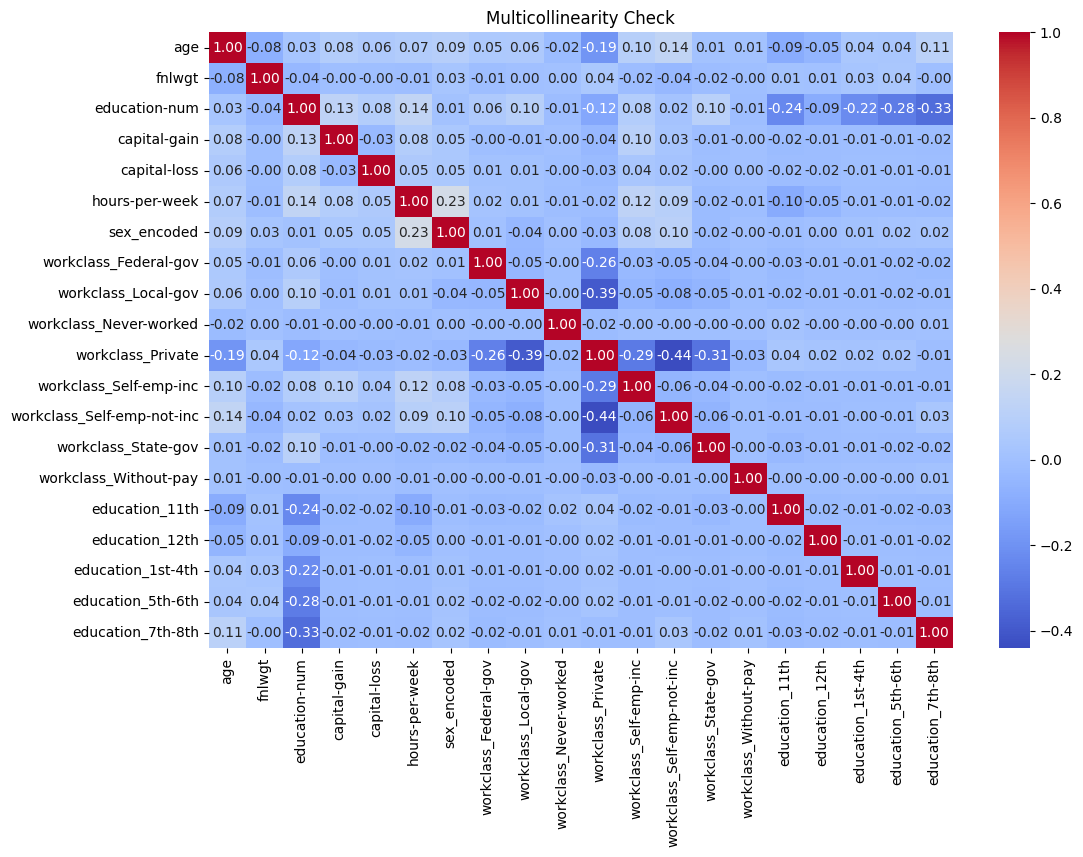

In [242]:
# Fetch and Encode
X_df = pd.get_dummies(adult.data.features, drop_first=True)
y_series = (adult.data.targets.iloc[:, 0].str.replace('.', '', regex=False).str.strip() == '>50K').astype(int)
df = X_df.copy()
df['income'] = y_series

# Heatmap for Multicollinearity Check
plt.figure(figsize=(12, 8))
sns.heatmap(X_df.iloc[:, :20].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Multicollinearity Check")
plt.show()

# Scale and Tensorize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_series.values, dtype=torch.float32).reshape(-1, 1)

# Train/Test Split (80/20)
split = int(0.8 * len(X_tensor))
X_train, X_test = X_tensor[:split], X_tensor[split:]
y_train, y_test = y_tensor[:split], y_tensor[split:]

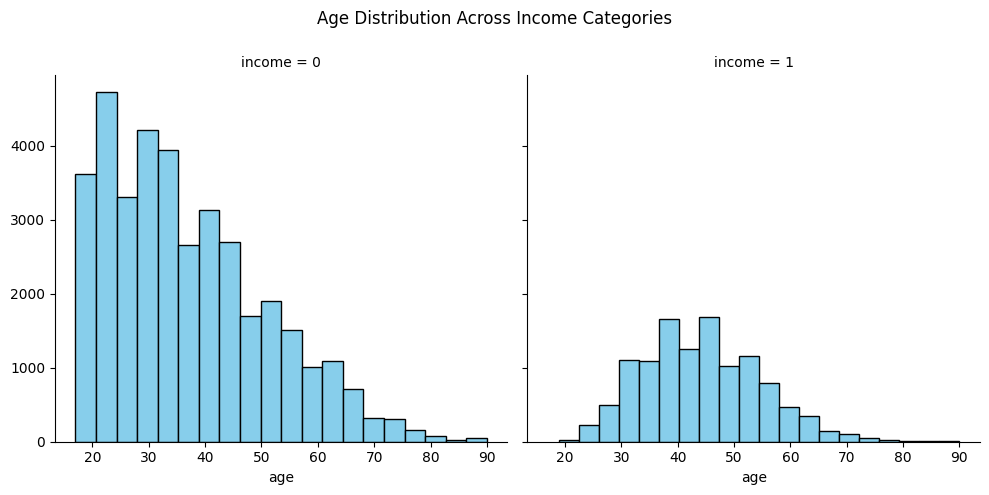

In [243]:
# FacetGrid: Distribution of Age by Income Level
g = sns.FacetGrid(df, col='income', height=5)
g.map(plt.hist, 'age', bins=20, color='skyblue', edgecolor='black')
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Age Distribution Across Income Categories')
plt.show()

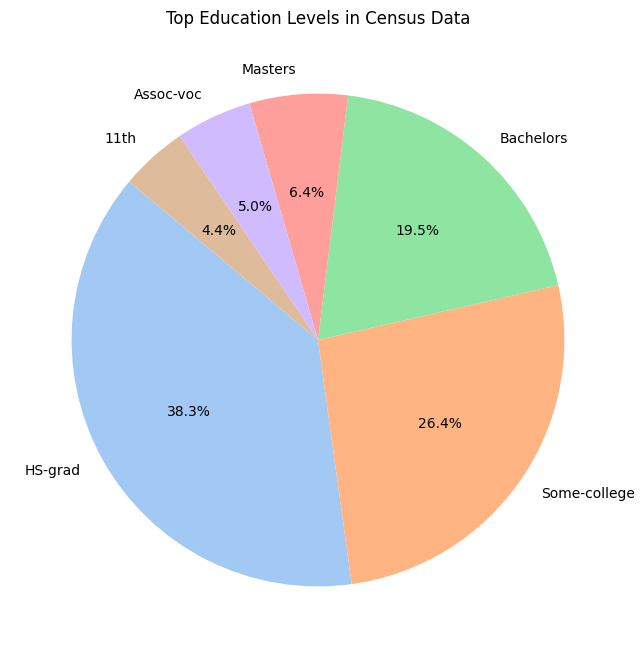

In [246]:
df_viz = adult.data.features.copy()
income_col = adult.data.targets.iloc[:, 0].str.replace('.', '', regex=False).str.strip()
df_viz['income'] = income_col

# Plot Pie Chart
fig, ax = plt.subplots(figsize=(8, 8))
edu_counts = df_viz['education'].value_counts().head(6)

ax.pie(x=edu_counts,
       labels=edu_counts.index,
       autopct='%1.1f%%',
       colors=sns.color_palette('pastel'),
       startangle=140)
ax.set_title('Top Education Levels in Census Data')
plt.show()

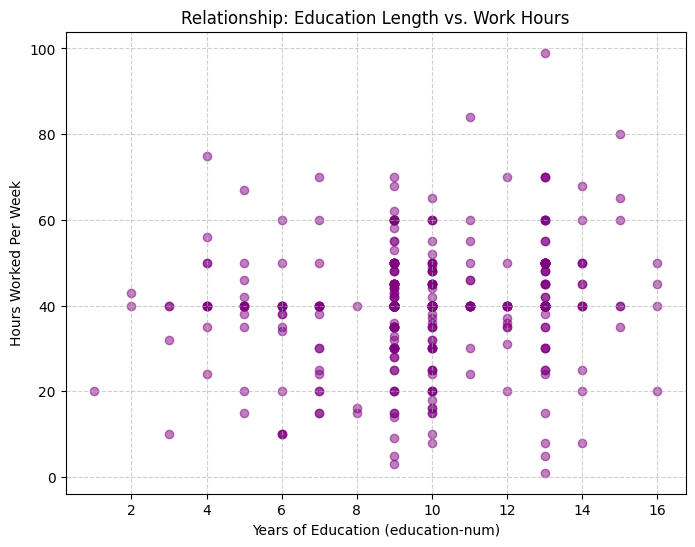

In [247]:
# Scatter Plot: Education Level vs. Hours Worked per Week
fig, ax = plt.subplots(figsize=(8, 6))
# Sampling 500 points so the plot isn't too crowded
sample_df = df.sample(500)

ax.scatter(sample_df['education-num'], sample_df['hours-per-week'], alpha=0.5, color='purple')
ax.set_xlabel('Years of Education (education-num)')
ax.set_ylabel('Hours Worked Per Week')
ax.set_title('Relationship: Education Length vs. Work Hours')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [215]:
# Initialize
input_dim = X_train.shape[1]
model = PyTorchNet(input_size=input_dim, hidden_size=10)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
for epoch in range(220):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.7320
Epoch 10, Loss: 0.7057
Epoch 20, Loss: 0.6820
Epoch 30, Loss: 0.6596
Epoch 40, Loss: 0.6374
Epoch 50, Loss: 0.6146
Epoch 60, Loss: 0.5909
Epoch 70, Loss: 0.5664
Epoch 80, Loss: 0.5416
Epoch 90, Loss: 0.5173
Epoch 100, Loss: 0.4940
Epoch 110, Loss: 0.4726
Epoch 120, Loss: 0.4534
Epoch 130, Loss: 0.4365
Epoch 140, Loss: 0.4219
Epoch 150, Loss: 0.4094
Epoch 160, Loss: 0.3987
Epoch 170, Loss: 0.3896
Epoch 180, Loss: 0.3819
Epoch 190, Loss: 0.3753
Epoch 200, Loss: 0.3697
Epoch 210, Loss: 0.3649


In [216]:
model.eval()
with torch.no_grad():
    # Get raw scores, apply sigmoid, and threshold at 0.5
    raw_outputs = model(X_test)
    probs = torch.sigmoid(raw_outputs)
    preds = (probs >= 0.5).float()

    accuracy = (preds == y_test).float().mean()
    print(f"\nFinal Framework Accuracy: {accuracy.item() * 100:.2f}%")


Final Framework Accuracy: 83.75%


# Description
### Hyperparameters
- We chose 10 hidden nodes to capture non-linear relationships, without overfitting.
- Learning rate: The learning rate was set to the standard value of 0.001 for Adam. This let to an increased amount of epochs because of the slower convergence but the approach is more conservative since the weights are influeced more slowly.
- Epochs: Through trial and error, I tested epoch values ranging from 100 to 300. The best results were found between 200 and 220 since the cost seemed to plateu after that point.

### Regularization
No regularization was used due to the simplicity of the network relative to the amount of data in our dataset (40k+)

### Optimization Algorithm
This implementation uses Adam because it implements varing learning rates which help the model emphasize the parameters that are contributing to reducing bias and variance.

# Normalized Inputs
The model only performs well due to the use of Scalar(). Capital gains and losses, for example, are not bound to specific ranges and may cause the model to give more importance to higher values. Its better for the input to be centered around 0, which is part of what the scalar does.

# Test on yourself!

In [180]:
import numpy as np

# Testing on personal data
my_data = {
    'age': 21,
    'workclass': 'Private',
    'fnlwgt': 200000, # This is a census weight, can be any average number
    'education': 'Bachelors',
    'education-num': 16,
    'marital-status': 'Never-married',
    'occupation': 'Prof-specialty',
    'relationship': 'Own-child',
    'race': 'White',
    'sex': 'Male',
    'capital-gain': 2000,
    'capital-loss': 1700,
    'hours-per-week': 40,
    'native-country': 'United-States'
}

The biggest contributors based on changing the values seem to be marital status, relationship, capital gain, and capital loss.

In [183]:
# Personal Dataframe
me_df = pd.DataFrame([my_data])

# One-Hot Encode (must use the same columns as the training set)
me_encoded = pd.get_dummies(me_df).reindex(columns=X_df.columns, fill_value=0)
me_scaled = scaler.transform(me_encoded)

# Convert to Tensor
me_tensor = torch.tensor(me_scaled, dtype=torch.float32)

In [184]:
model.eval()
with torch.no_grad():
    prediction_logit = model(me_tensor)
    probability = torch.sigmoid(prediction_logit).item()

print(f"Probability of making >50K: {probability * 100:.2f}%")

if probability > 0.5:
    print("Result: High Income (>50K)")
else:
    print("Result: Low Income (<=50K)")

Probability of making >50K: 13.55%
Result: Low Income (<=50K)
